In [1]:
import time
import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.animation import FuncAnimation
from conv_sparse_model import ConvSparseLayer

from train_conv3d_sparse_model import load_balls_data
from train_conv3d_sparse_model import plot_original_vs_recon
from train_conv3d_sparse_model import plot_filters

from IPython.display import HTML

In [29]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
if device == "cpu":
    batch_size = 1
else:
    batch_size = 32*3

train_loader = load_balls_data(batch_size)

example_data = next(iter(train_loader))

sparse_layer = ConvSparseLayer(in_channels=1,
                               out_channels=16,
                               kernel_size=5,
                               stride=1,
                               padding=0,
                               convo_dim=3,
                               rectifier=True,
                               shrink=0.25,
                               lam=0.5,
                               max_activation_iter=200)
model = torch.nn.DataParallel(sparse_layer, device_ids=[1, 2, 3])
model.to(device)

learning_rate = 1e-2
filter_optimizer = torch.optim.Adam(sparse_layer.parameters(),
                                    lr=learning_rate)

In [ ]:
for epoch in range(10):
    for local_batch in train_loader:
        local_batch = local_batch.to(device)
        t1 = time.perf_counter()
        activations = model(local_batch)
        t2 = time.perf_counter()
        print('activations took {} sec'.format(t2-t1))
        loss = sparse_layer.loss(local_batch, activations)
        print('epoch={}, loss={}'.format(epoch, loss))
        print()

        filter_optimizer.zero_grad()
        loss.backward()
        filter_optimizer.step()
        sparse_layer.normalize_weights()

activations took 1.661946034990251 sec
epoch=0, loss=1314.551513671875

activations took 0.8709160540020093 sec
epoch=0, loss=1325.52685546875

activations took 1.680383646977134 sec
epoch=1, loss=1234.9676513671875

activations took 0.9770810909685679 sec
epoch=1, loss=1342.311767578125

activations took 1.655958016985096 sec
epoch=2, loss=1147.7120361328125

activations took 0.6569773370283656 sec
epoch=2, loss=1137.9063720703125

activations took 1.674271558993496 sec
epoch=3, loss=1569.4112548828125

activations took 0.8271896369988099 sec
epoch=3, loss=1094.10009765625

activations took 1.6511999040376395 sec
epoch=4, loss=1013.516845703125

activations took 0.9986954620108008 sec
epoch=4, loss=1138.869384765625



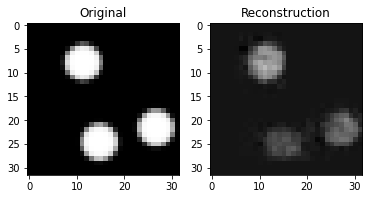

In [31]:
activations = sparse_layer(example_data[:1].to(device))
reconstructions = sparse_layer.reconstructions(
    activations).cpu().detach().numpy()

ani = plot_original_vs_recon(example_data, reconstructions, idx=0)
HTML(ani.to_html5_video())

In [ ]:
ani = plot_filters(sparse_layer.filters.cpu().detach())
HTML(ani.to_html5_video())